In [1]:
from ANNarchy import *
from ANNarchy.extensions.bold import *

import numpy as np
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK

ANNarchy 4.7 (4.7.2.4) on darwin (posix).


In [2]:
def create_network():

    clear()

    Izhikevich = Neuron(
        parameters="""
            noise = 0.0
            a = 0.02
            b = 0.2
            c = -65.0
            d = 2.0 
            v_thresh = 30.0
            current = 0.0
        """,
        equations="""
            I = g_exc - g_inh + noise * Normal(0.0, 1.0) + current

            dv/dt = 0.04 * v^2 + 5.0 * v + 140.0 - u + I 
            
            du/dt = a * (b*v - u) 
        """,
        spike = """
            v >= v_thresh
        """,
        reset = """
            v = c
            u += d
        """
    )

    pop = Population(geometry=1000, neuron=Izhikevich)
    Exc = pop[:800]
    Inh = pop[800:]

    # Compute mean firing rate in Hz on 100ms window
    pop.compute_firing_rate(window=100.0)
    
    re = np.random.random(800)      ; ri = np.random.random(200)
    Exc.noise = 5.0                 ; Inh.noise = 2.0
    Exc.a = 0.02                    ; Inh.a = 0.02 + 0.08 * ri
    Exc.b = 0.2                     ; Inh.b = 0.25 - 0.05 * ri
    Exc.c = -65.0 + 15.0 * re**2    ; Inh.c = -65.0
    Exc.d = 8.0 - 6.0 * re**2       ; Inh.d = 2.0
    Exc.v = -65.0                   ; Inh.v = -65.0
    Exc.u = Exc.v * Exc.b           ; Inh.u = Inh.v * Inh.b

    exc_proj = Projection(pre=Exc, post=pop, target='exc')
    exc_proj.connect_all_to_all(weights=Uniform(0.0, 0.5))
    
    inh_proj = Projection(pre=Inh, post=pop, target='inh')
    inh_proj.connect_all_to_all(weights=Uniform(0.0, 1.0))

    return pop

In [3]:
def compute_loss(data):
    
    max_bold = data.max()
    loss = (max_bold - 0.05)**2

    return loss

In [4]:
def trial(args):

    pop = create_network()

    m_rate = Monitor(pop, ["r"])

    m_bold = BoldMonitor(
        
        populations = pop, # recorded population
        
        bold_model = balloon_RN(), # BOLD model to use (default is balloon_RN)
        
        mapping = {'I_CBF': 'r'}, # mapping from pop.r to I_CBF
        
        normalize_input = 2000,  # time window to compute baseline.
        
        recorded_variables = ["I_CBF", "BOLD"]  # variables to be recorded in the BOLD model
    )

    compile()

    m_bold.start()

    # We manipulate the noise for the half of the neurons
    simulate(5000)      # 5s with low noise
    pop[:800].current = args[0]
    simulate(500)      # 500ms with higher noise (one population)
    pop[:800].current = 0.0
    simulate(20000)     # 10s with low noise

    # Retrieve the recordings
    mean_fr = np.mean(m_rate.get("r"), axis=1)

    input_data = m_bold.get("I_CBF")
    bold_data = m_bold.get("BOLD")

    # Compute the loss
    loss = compute_loss(bold_data)

    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'mean_fr': mean_fr,
        'input_data': input_data,
        'bold_data': bold_data,
        }

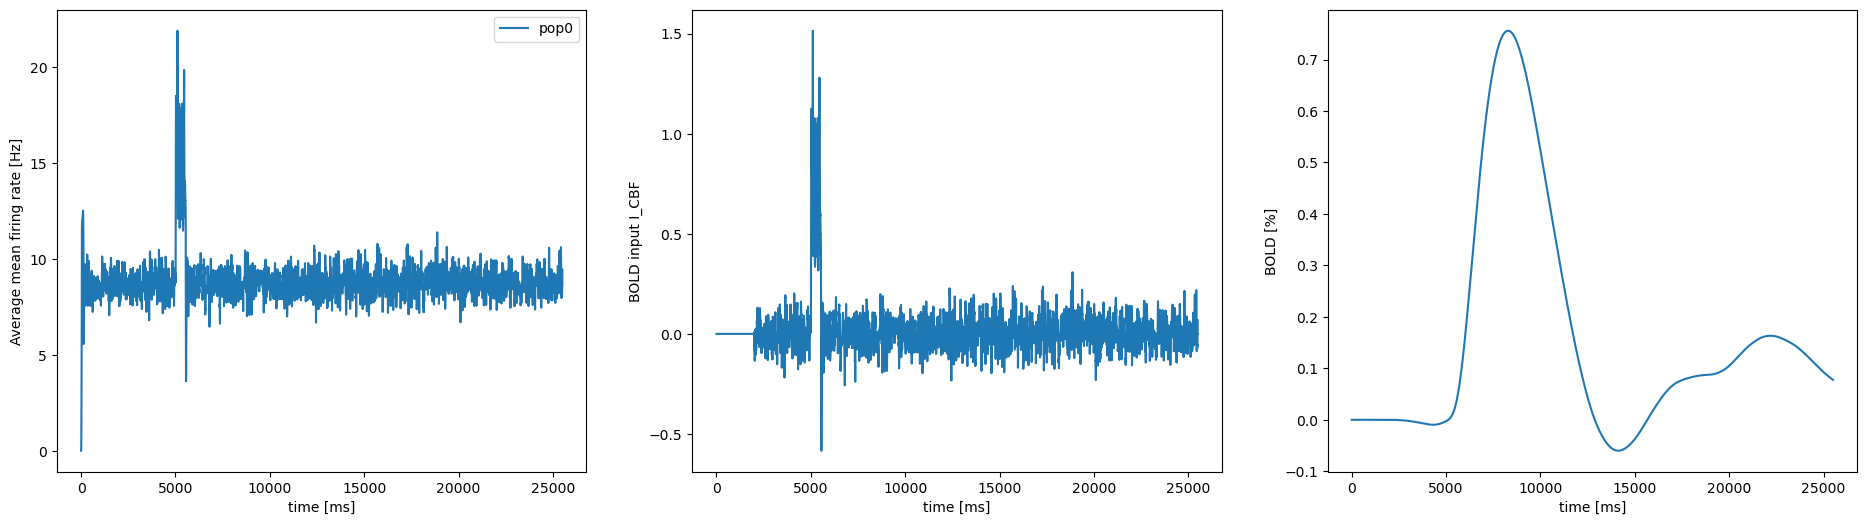

In [6]:
data = trial([1.0])

plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])

ax1.plot(data['mean_fr'], label="pop0")
plt.legend()
ax1.set_ylabel("Average mean firing rate [Hz]")

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(data['input_data'])
ax2.set_ylabel("BOLD input I_CBF")

# BOLD output signal
ax3 = plt.subplot(grid[0, 2])

ax3.plot(data['bold_data']*100.0)
ax3.set_ylabel("BOLD [%]")

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("time [ms]")

plt.show()

In [7]:
best = fmin(
    fn=trial,
    space=[
        hp.uniform('current', 0.0, 5.0), 
    ],
    algo=tpe.suggest,
    max_evals=100)
print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [11:06<00:00,  6.66s/trial, best loss: 9.761940927367129e-06]
{'current': 3.83953104086519}


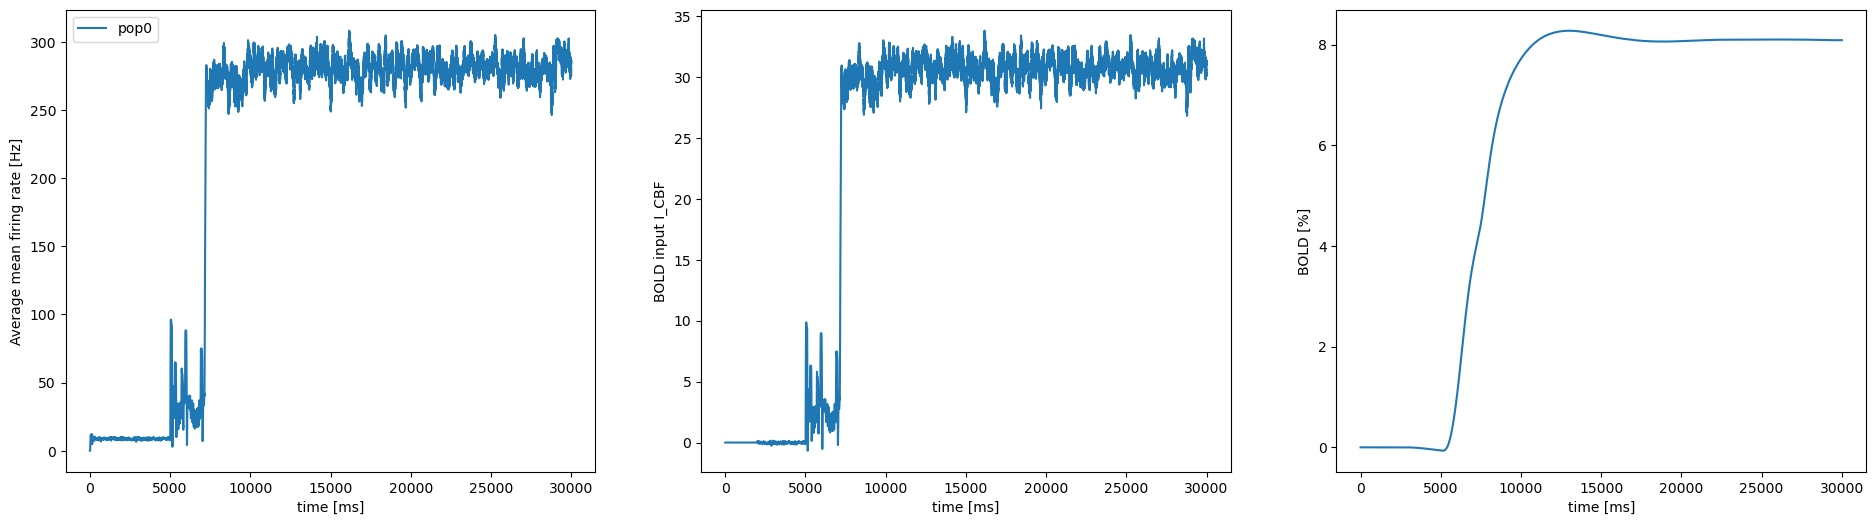

In [8]:
data = trial(list(best.values()))

plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])

ax1.plot(data['mean_fr'], label="pop0")
plt.legend()
ax1.set_ylabel("Average mean firing rate [Hz]")

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(data['input_data'])
ax2.set_ylabel("BOLD input I_CBF")

# BOLD output signal
ax3 = plt.subplot(grid[0, 2])

ax3.plot(data['bold_data']*100.0)
ax3.set_ylabel("BOLD [%]")

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("time [ms]")

plt.show()